In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The autoreload module is not an IPython extension.


UsageError: Line magic function `%autoreload` not found.


In [2]:
import pandas as pd
import statsmodels.api as sm


dir = "../data/"
cdf = pd.read_csv(dir+"data4columbia_credit.csv")
cdf.columns=['company','date','data']
cdf.date = pd.to_datetime(cdf.date)

t = (cdf["date"] - pd.Timestamp("1900-01-01")).dt.total_seconds().to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)
cdf['t'] = t

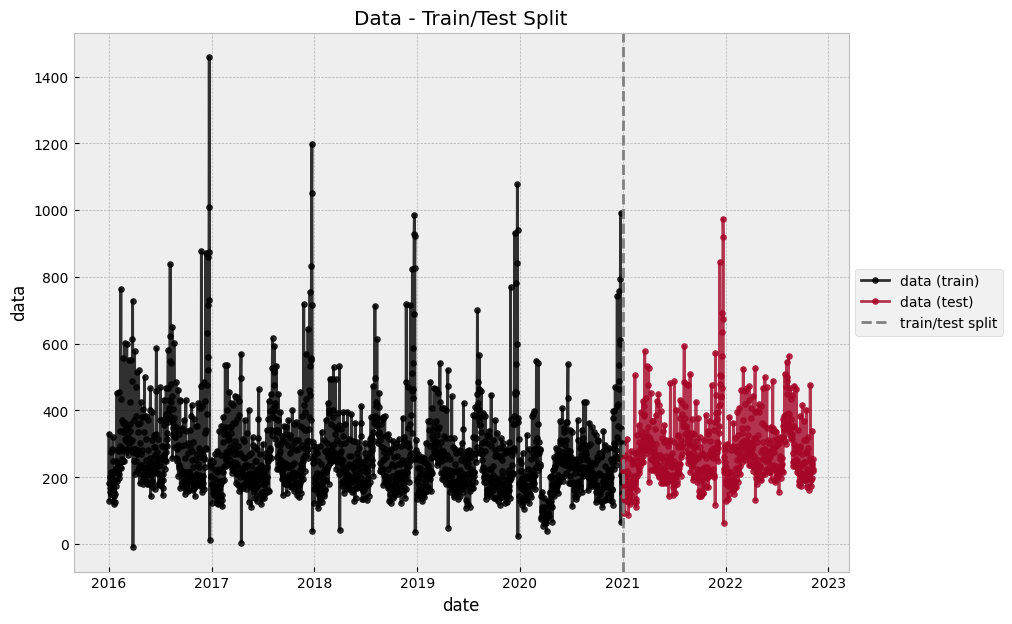

In [3]:
import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)

def run_decompose(cdf, company_id, split_date):
    data = cdf[cdf.company==cdf.company.unique()[company_id]].set_index('date')
    df_train = data[data.index < split_date]
    df_test = data[data.index >= split_date]
    return df_train, df_test

train_test_date =  datetime.datetime(2021,1,1)
df_train, df_test = run_decompose(cdf, 1, train_test_date)
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="data",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="data",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="data (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Data - Train/Test Split");

In [4]:
x_train = df_train['t']
y_train = df_train.data

x_test = df_test['t']
y_test = df_test.data

/var/folders/g0/vly43npx24nf2s_dtjcp9lq80000gn/T/ipykernel_1384/2173828918.py:2: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
Sampling: [lag_coefs, likelihood, α, β, β_fourier_yr, σ]


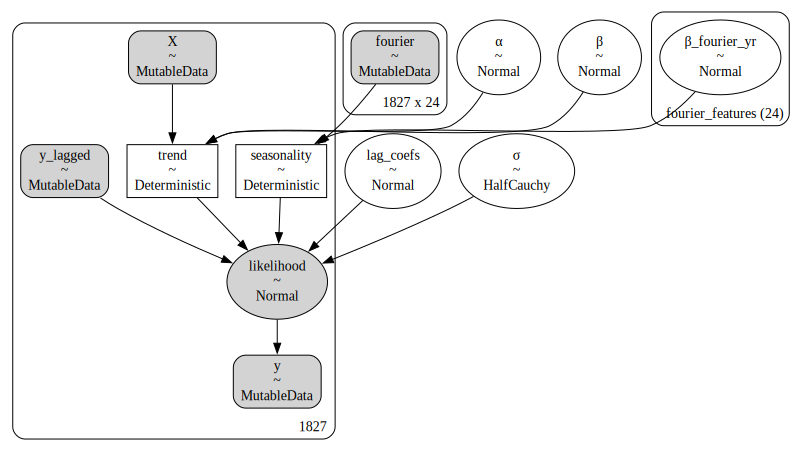

In [5]:
import numpy as np
from scipy.ndimage.interpolation import shift


"""
data ~ (α + βX) + seasonality + ar
seasonality ~ β_four * fourier_modes
"""

df_train['date'] = df_train.index
date_train = df_train["date"]
data_train = df_train["data"]

df = df_train

#fourier modes
n_order = 12
periods = df_train["date"].dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)


coords = {
    "fourier_features": np.arange(2 * n_order),
}


with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    
    # data containers
    X = pm.MutableData("X", x_train)
    y = pm.MutableData("y", y_train)
    y_lagged = pm.MutableData("y_lagged", shift(y_train,1,cval=y_train.mean())) 
    
    X_four = pm.MutableData("fourier", fourier_features)
    
    α = pm.Normal("α", mu=np.mean(y_train), sigma=np.std(y_train))
    β = pm.Normal("β", mu=0, sigma=1)
    σ = pm.HalfCauchy("σ", beta=0.1)
    
    lag_coef = pm.Normal("lag_coefs", mu=0, sigma=1)
    
    β_fourier_yr = pm.Normal("β_fourier_yr", mu=0, sigma=10, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier_yr, X_four.T)
    )
    
    init = pm.Normal.dist(0, size=1)
    
    trend = pm.Deterministic("trend", α + β * X)
    ar = lag_coef * y_lagged
    
    #additive seasonality
    μ = trend + seasonality + ar
    
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(linear_with_seasonality)


In [6]:
linear_with_seasonality

           α ~ N(267, 132)
           β ~ N(0, 1)
           σ ~ C**+(0, 0.1)
   lag_coefs ~ N(0, 1)
β_fourier_yr ~ N(0, 10)
 seasonality ~ Deterministic(f(β_fourier_yr))
       trend ~ Deterministic(f(α, β))
  likelihood ~ N(f(lag_coefs, β_fourier_yr, α, β), σ)

Sampling: [lag_coefs, likelihood, α, β, β_fourier_yr, σ]


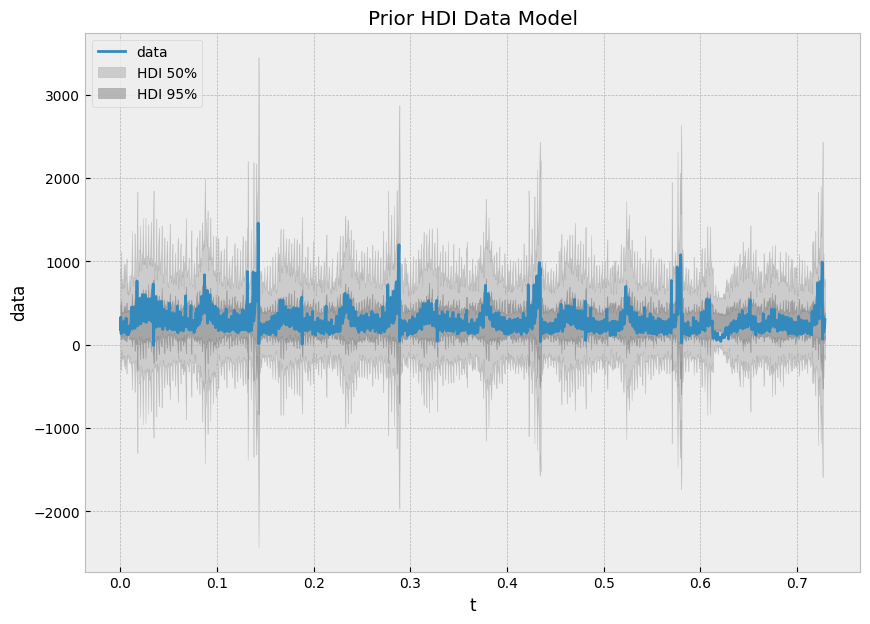

In [7]:
with linear_with_seasonality:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)
fig, ax = plt.subplots()

sns.lineplot(
    x="t", y="data", data=df_train, color="C0", label="data", ax=ax
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Data Model");

In [8]:
with linear_with_seasonality:
    temp_idata = pm.sample(
        target_accept=0.9, draws=4000, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)
    
az.summary(data=temp_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ, lag_coefs, β_fourier_yr]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 110 seconds.
Sampling: [likelihood]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,160.407,6.209,148.872,172.150,0.047,0.033,17682.0,13293.0,1.0
β,-0.519,1.003,-2.423,1.330,0.005,0.008,33789.0,11173.0,1.0
lag_coefs,0.400,0.021,0.360,0.440,0.000,0.000,16570.0,12587.0,1.0
β_fourier_yr[0],-4.266,3.137,-10.054,1.670,0.018,0.017,30987.0,12043.0,1.0
β_fourier_yr[1],7.905,3.147,2.127,13.904,0.017,0.014,35434.0,11536.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[1822],160.029,6.193,148.226,171.373,0.046,0.033,17880.0,13240.0,1.0
trend[1823],160.029,6.193,148.226,171.372,0.046,0.033,17880.0,13240.0,1.0
trend[1824],160.029,6.193,148.226,171.372,0.046,0.033,17881.0,13240.0,1.0
trend[1825],160.029,6.193,148.226,171.371,0.046,0.033,17881.0,13269.0,1.0


array([[<AxesSubplot:title={'center':'β_fourier_yr'}>,
        <AxesSubplot:title={'center':'β_fourier_yr'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'lag_coefs'}>,
        <AxesSubplot:title={'center':'lag_coefs'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

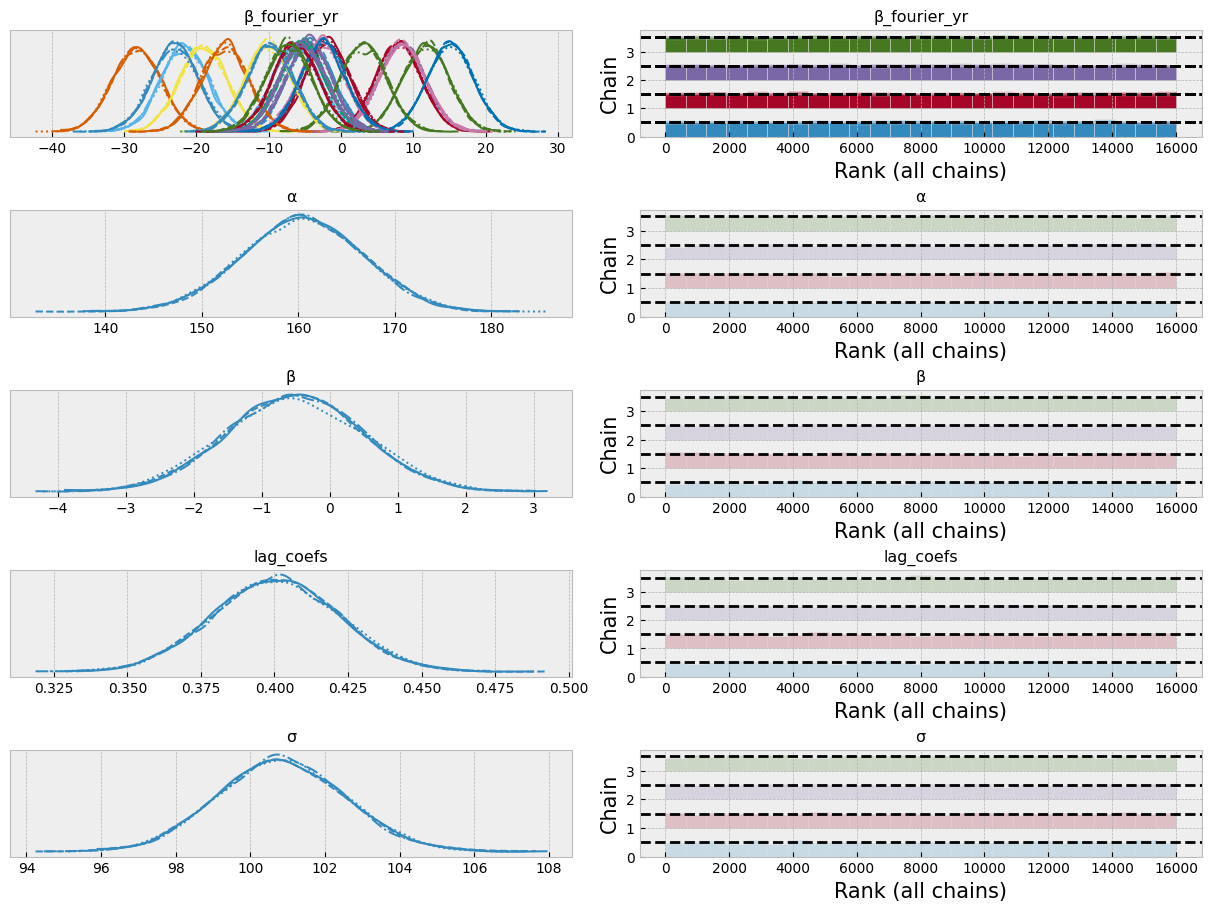

In [9]:
az.plot_trace(
    data=temp_idata,
    compact=True,
    var_names=["β_fourier_yr",'α','β','lag_coefs','σ'],
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)

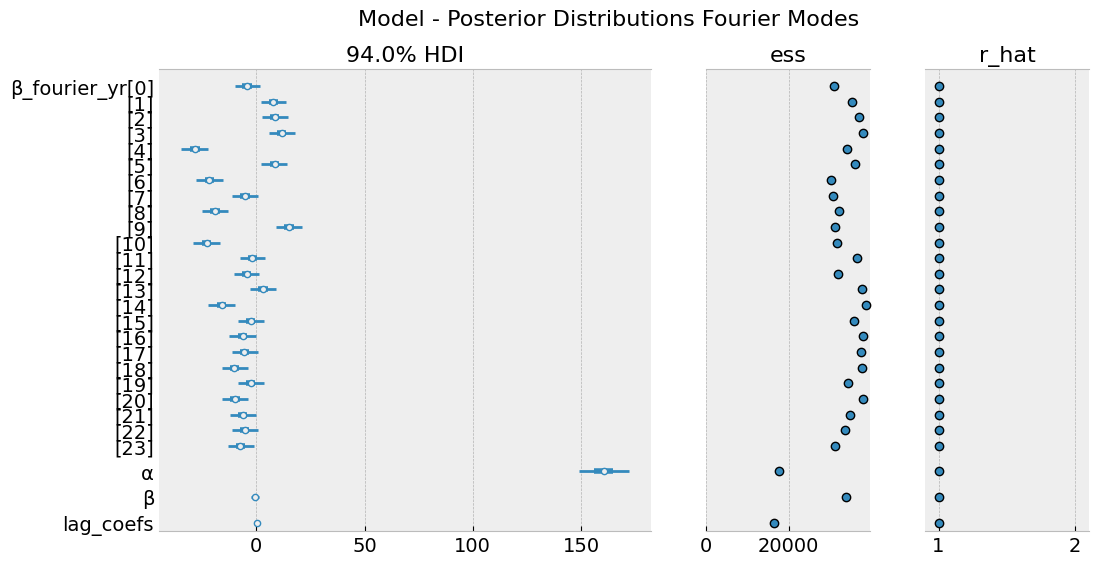

In [10]:
ax = az.plot_forest(
    kind="forestplot",
    data=temp_idata,
    var_names=["β_fourier_yr",'α','β','lag_coefs'],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Model - Posterior Distributions Fourier Modes", fontsize=16
);

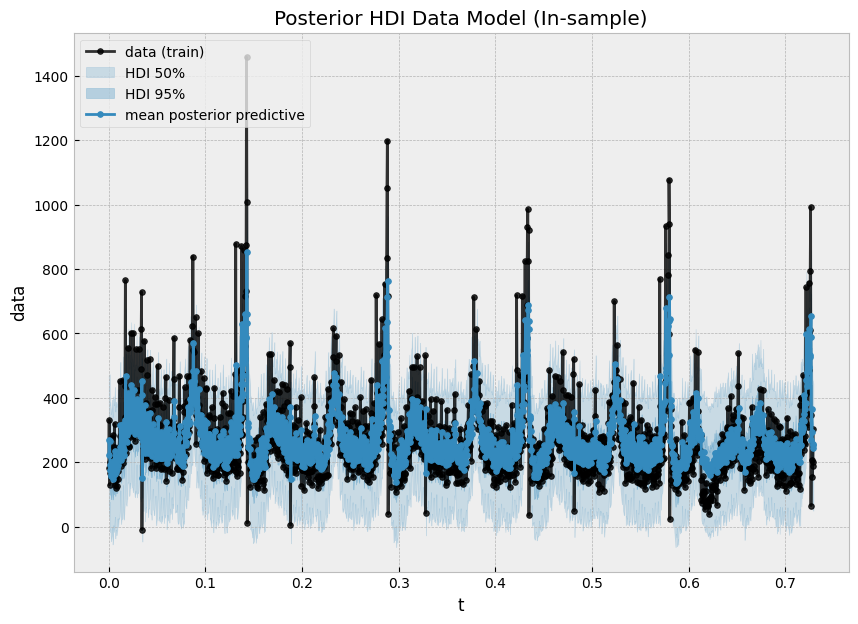

In [11]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Data Model (In-sample)");

In [12]:
# Update data reference.

#fourier
n_order = 12
df_test['date'] = df_test.index
periods = df_test["date"].dt.dayofyear / 365.25
fourier_features_test = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

with linear_with_seasonality:
    pm.set_data({"X": x_test, 'y':y_test, 'fourier' : fourier_features_test, 'y_lagged': shift(y_test,1)})
    ppc_test = pm.sample_posterior_predictive(temp_idata, model=linear_with_seasonality)
ppc_test

Sampling: [likelihood]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

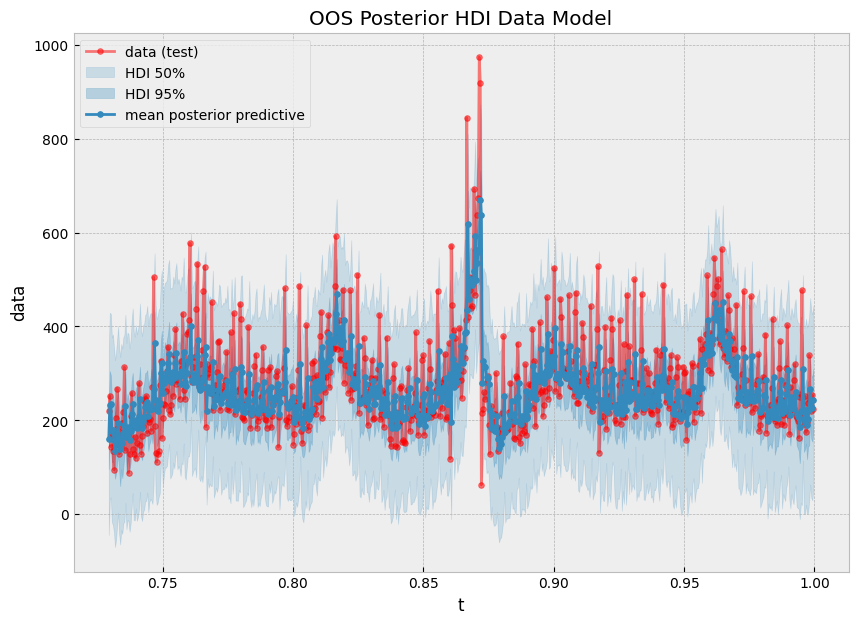

In [13]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_test,
    marker="o",
    color="red",
    alpha=0.5,
    markersize=4,
    markeredgecolor="red",
    label="data (test)",
)
az.plot_hdi(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="OOS Posterior HDI Data Model");